In [1]:
%pip install -q nltk scikit-learn matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Setup: imports, configs, paths
import os, re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

import nltk
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Reproducibility
RANDOM_SEED = int(os.getenv("RANDOM_SEED", "42"))
np.random.seed(RANDOM_SEED)

# Plot defaults
plt.rcParams["figure.figsize"] = (4, 4)

# Dataset paths (configurable)
FAKE_DATASET = os.getenv("FAKE_DATASET", "/workspaces/DS510-Team-Project/Datasets/Fake.csv")
TRUE_DATASET = os.getenv("TRUE_DATASET", "/workspaces/DS510-Team-Project/Datasets/True.csv")

In [3]:
def load_datasets(
    fake_path: str = FAKE_DATASET,
    true_path: str = TRUE_DATASET,
    seed: int = RANDOM_SEED,
) -> pd.DataFrame:
    """Load, label, and shuffle fake/true news datasets."""

    # Read CSVs
    fake_df = pd.read_csv(fake_path)
    true_df = pd.read_csv(true_path)

    fake_df["label"] = 0  # Fake
    true_df["label"] = 1  # Real

    # Combine
    df = pd.concat([fake_df, true_df], ignore_index=True)

    # Keep only useful columns
    keep = [c for c in ["title", "text", "subject", "date", "label"] if c in df.columns]
    df = df[keep]

    # Basic validation
    if not {"title", "text"}.issubset(df.columns):
        raise ValueError("Both 'title' and 'text' columns are required.")

    # Shuffle + reset index
    return df.sample(frac=1.0, random_state=seed).reset_index(drop=True)


# Load dataset
df = load_datasets()
print("Combined shape:", df.shape)
df.head()

Combined shape: (44898, 5)


,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [4]:
# Text preprocessing
try:
    from nltk.corpus import stopwords
    STOPWORDS = set(stopwords.words("english"))
except Exception:
    STOPWORDS = {
        "a","about","above","after","again","against","all","am","an","and","any","are","as","at",
        "be","because","been","before","being","below","between","both","but","by","could","did",
        "do","does","doing","down","during","each","few","for","from","further","had","has","have",
        "having","he","her","here","hers","him","his","how","i","if","in","into","is","it","its",
        "itself","me","more","most","my","myself","of","on","once","only","or","other","our",
        "ours","out","over","own","same","she","should","so","some","such","than","that","the",
        "their","theirs","them","themselves","then","there","these","they","this","those","through",
        "to","too","under","until","up","very","was","we","were","what","when","where","which",
        "while","who","whom","why","with","you","your","yours","yourself","yourselves"
    }

# Keep negations
STOPWORDS -= {"no", "not", "nor"}

# Lemmatizer preferred; fallback to stemmer
try:
    nltk.data.find("corpora/wordnet")
    NORMALIZER = WordNetLemmatizer()
    USE_LEMMA = True
except LookupError:
    NORMALIZER = PorterStemmer()
    USE_LEMMA = False

CLEAN_RE = re.compile(r"[^a-zA-Z\s]")

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    return re.sub(r"\s+", " ", CLEAN_RE.sub(" ", s.lower())).strip()

def preprocess_text(s: str) -> str:
    tokens = wordpunct_tokenize(clean_text(s))
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 1]
    if USE_LEMMA:
        tokens = [NORMALIZER.lemmatize(t) for t in tokens]
    else:
        tokens = [NORMALIZER.stem(t) for t in tokens]
    return " ".join(tokens)

def build_body_column(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["body"] = (out["title"].fillna("") + ". " + out["text"].fillna("")).str.strip()
    return out

# Apply preprocessing
df = build_body_column(df)
df["body_clean"] = df["body"].apply(preprocess_text)

print("Cleaned sample:")
df[["body", "body_clean"]].head()

Cleaned sample:


,body,body_clean
0,Ben Stein Calls Out 9th Circuit Court: Committ...,ben stein call th circuit court commit coup ta...
1,Trump drops Steve Bannon from National Securit...,trump drop steve bannon nation secur council w...
2,Puerto Rico expects U.S. to lift Jones Act shi...,puerto rico expect lift jone act ship restrict...
3,OOPS: Trump Just Accidentally Confirmed He Lea...,oop trump accident confirm leak isra intellig ...
4,Donald Trump heads for Scotland to reopen a go...,donald trump head scotland reopen golf resort ...


Primary (LogReg)
Accuracy : 0.9893
Precision: 0.9843
Recall   : 0.9935
F1-score : 0.9888

              precision    recall  f1-score   support

           0     0.9940    0.9855    0.9897      4696
           1     0.9843    0.9935    0.9888      4284

    accuracy                         0.9893      8980
   macro avg     0.9891    0.9895    0.9893      8980
weighted avg     0.9894    0.9893    0.9893      8980



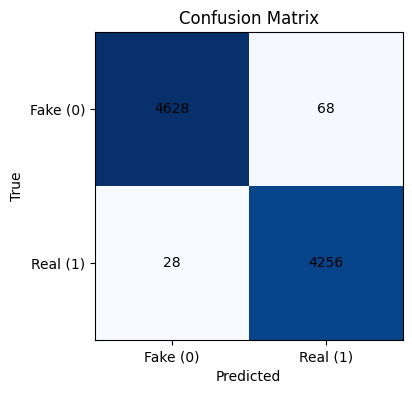

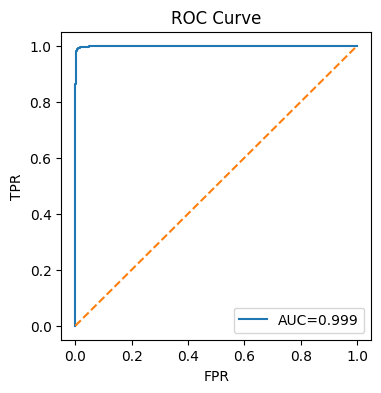

ROC-AUC : 0.9993

Baseline comparison:


,Model,Acc,Prec,Rec,F1,AUC
1,LinearSVC (calibrated),0.995434,0.994868,0.995565,0.995216,0.999799
0,LogReg,0.989310,0.984274,0.993464,0.988848,0.999329


Saved model to: /workspaces/DS510-Team-Project/Outputs/tfidf_logreg_pipeline.joblib


In [5]:
# Model training & evaluation

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from joblib import dump
from pathlib import Path

# Split data
X = df["body_clean"].fillna("")
y = df["label"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

# Primary pipeline: TF-IDF + Logistic Regression
model = make_pipeline(
    TfidfVectorizer(max_features=5000, ngram_range=(1, 2)),
    LogisticRegression(max_iter=200, solver="liblinear",
                       class_weight="balanced", random_state=RANDOM_SEED)
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Metrics
def print_metrics(y_true, y_pred, title="Metrics"):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    print(f"{title}\n"
          f"Accuracy : {acc:.4f}\n"
          f"Precision: {prec:.4f}\n"
          f"Recall   : {rec:.4f}\n"
          f"F1-score : {f1:.4f}\n")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))
    return acc, prec, rec, f1

print_metrics(y_test, y_pred, "Primary (LogReg)")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap="Blues")
plt.xticks([0, 1], ["Fake (0)", "Real (1)"])
plt.yticks([0, 1], ["Fake (0)", "Real (1)"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC
if hasattr(model[-1], "predict_proba"):
    y_score = model.predict_proba(X_test)[:, 1]
elif hasattr(model[-1], "decision_function"):
    y_score = model.decision_function(X_test)
else:
    y_score = None

if y_score is not None:
    auc = roc_auc_score(y_test, y_score)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title("ROC Curve"); plt.legend(); plt.show()
    print(f"ROC-AUC : {auc:.4f}")

# Baselines
baselines = {
    "LogReg": model,
    "LinearSVC (calibrated)": make_pipeline(
        TfidfVectorizer(max_features=5000, ngram_range=(1, 2)),
        CalibratedClassifierCV(LinearSVC(), method="sigmoid", cv=3)
    ),
}

rows = []
for name, mdl in baselines.items():
    mdl.fit(X_train, y_train)
    yp = mdl.predict(X_test)
    auc = np.nan
    if hasattr(mdl[-1], "predict_proba"):
        auc = roc_auc_score(y_test, mdl.predict_proba(X_test)[:, 1])
    elif hasattr(mdl[-1], "decision_function"):
        auc = roc_auc_score(y_test, mdl.decision_function(X_test))
    rows.append((name,
                 accuracy_score(y_test, yp),
                 precision_score(y_test, yp, zero_division=0),
                 recall_score(y_test, yp, zero_division=0),
                 f1_score(y_test, yp, zero_division=0),
                 auc))

baseline_df = pd.DataFrame(rows, columns=["Model", "Acc", "Prec", "Rec", "F1", "AUC"])
print("\nBaseline comparison:")
display(baseline_df.sort_values("F1", ascending=False))

# Save primary model
OUT_DIR = Path("/workspaces/DS510-Team-Project/Outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
dump(model, OUT_DIR / "tfidf_logreg_pipeline.joblib")
print(f"Saved model to: {OUT_DIR / 'tfidf_logreg_pipeline.joblib'}")

In [6]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

def top_terms(pipeline: Pipeline, class_label: int, top_k: int = 20):
    """
    Get top weighted terms for a given class (e.g., 0=fake, 1=real).
    Works for linear classifiers with coef_ (LogReg, LinearSVC).
    """
    vec: TfidfVectorizer = pipeline.named_steps["tfidfvectorizer"]
    est = list(pipeline.named_steps.values())[-1]  # last step = classifier
    
    w = est.coef_
    classes = getattr(est, "classes_", np.array([0, 1]))

    # Handle binary logistic regression (coef_.shape = (1, n_features))
    if w.shape[0] == 1 and len(classes) >= 2:
        positive_label = classes[1]
        weights = w[0] if class_label == positive_label else -w[0]
    else:
        idx = np.where(classes == class_label)[0][0]
        weights = w[idx]

    feature_names = vec.get_feature_names_out()
    idx = np.argsort(weights)[-top_k:][::-1]
    return list(zip(feature_names[idx], weights[idx]))

def print_top_terms(pipeline: Pipeline, top_k: int = 20):
    """Print top terms for fake (0) and real (1) classes."""
    print("Top terms for Real (1):")
    for term, w in top_terms(pipeline, class_label=1, top_k=top_k):
        print(f"{term:25s} {w:.4f}")
    print("\nTop terms for Fake (0):")
    for term, w in top_terms(pipeline, class_label=0, top_k=top_k):
        print(f"{term:25s} {w:.4f}")

# --- Usage ---
print_top_terms(model, top_k=20)

Top terms for Real (1):
reuter                    22.3288
said                      14.9143
washington reuter         8.9958
presid donald             5.0711
wednesday                 4.5406
washington                4.5318
reuter presid             4.4051
tuesday                   4.1756
thursday                  3.9191
friday                    3.6433
nov                       3.4581
monday                    3.3079
minist                    3.2462
presidenti                3.1631
said statement            3.0216
edt                       2.8966
told report               2.8488
presid barack             2.8171
republican                2.8029
statement                 2.6235

Top terms for Fake (0):
via                       9.8772
video                     8.6407
us                        6.6859
imag                      5.9664
presid trump              5.5163
read                      5.4642
hillari                   5.1770
gop                       5.1680
mr                       

In [7]:
import nltk

def ensure_nltk():
    resources = {
        "punkt": "tokenizers/punkt",
        "stopwords": "corpora/stopwords",
        "wordnet": "corpora/wordnet",
        "omw-1.4": "corpora/omw-1.4",
    }
    for pkg, path in resources.items():
        try:
            nltk.data.find(path)
        except LookupError:
            nltk.download(pkg, quiet=True)

ensure_nltk()
print("NLTK resources ready (punkt, stopwords, wordnet, omw-1.4)")

NLTK resources ready (punkt, stopwords, wordnet, omw-1.4)


In [8]:
# Install Google Cloud + Vertex AI SDKs
%pip install -q --upgrade google-cloud-aiplatform vertexai google-generativeai

Note: you may need to restart the kernel to use updated packages.


In [10]:
# Google Cloud ADC
import os, json
from pathlib import Path

JSON_KEY_PATH = Path(os.getenv(
    "GOOGLE_APPLICATION_CREDENTIALS",
    "/workspaces/DS510-Team-Project/GCP_SA_KEY.json"
))

def validate_sa_json(path: Path):
    if not path.exists():
        return None
    try:
        with path.open("r", encoding="utf-8") as f:
            data = json.load(f)
        if {"type", "project_id", "private_key_id", "client_email"} <= set(data):
            return data
    except Exception:
        return None
    return None

sa_info = validate_sa_json(JSON_KEY_PATH)

if sa_info:
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(JSON_KEY_PATH)
    print(f"ADC ready from: {JSON_KEY_PATH}")
    print(f"   project_id: {sa_info['project_id']}")
else:
    print("No service account key found.")
    print("Set GOOGLE_APPLICATION_CREDENTIALS or run `gcloud auth application-default login`.")

ADC ready from: /workspaces/DS510-Team-Project/GCP_SA_KEY.json
   project_id: truthgen-ai-news-filter


In [11]:
# Vertex AI init (concise version)
import os
import vertexai
from vertexai.generative_models import GenerativeModel
from google.auth import default as google_auth_default
from google.auth.exceptions import DefaultCredentialsError

# Get ADC credentials
try:
    creds, detected_project = google_auth_default()
except DefaultCredentialsError:
    creds, detected_project = None, None

# Show active principale
principal = getattr(creds, "service_account_email", None) if creds else None
if principal:
    print(f"Authenticated as: {principal}")

# Resolve project + region
PROJECT_ID = os.getenv("GCP_PROJECT_ID", detected_project)
if not PROJECT_ID:
    raise RuntimeError("PROJECT_ID not resolved. Set GCP_PROJECT_ID or use ADC with a project.")

ALLOWED_REGIONS = {
    "us-central1","us-east1","us-west1",
    "europe-west1","europe-west4",
    "asia-northeast1","asia-east1"
}
LOCATION = os.getenv("VERTEX_LOCATION", "us-central1")
if LOCATION not in ALLOWED_REGIONS:
    raise ValueError(f"Invalid Vertex AI region '{LOCATION}'. Must be one of: {sorted(ALLOWED_REGIONS)}")

print(f"Project: {PROJECT_ID} | Region: {LOCATION}")

# Init Vertex AI
vertexai.init(project=PROJECT_ID, location=LOCATION)

# Optional connectivity check
try:
    GenerativeModel("gemini-2.5-pro").count_tokens("ping")
    print(" Vertex AI generative endpoint reachable")
except Exception as e:
    print(f"Warning: Vertex AI check failed ({e})")

Authenticated as: github-codespaces-access@truthgen-ai-news-filter.iam.gserviceaccount.com
Project: truthgen-ai-news-filter | Region: us-central1
 Vertex AI generative endpoint reachable


In [12]:
%pip install --upgrade google-cloud-aiplatform vertexai google-generativeai

  Using cached google_cloud_aiplatform-1.111.0-py2.py3-none-any.whl.metadata (38 kB)
  Using cached google_genai-1.34.0-py3-none-any.whl.metadata (43 kB)
  Using cached websockets-15.0.1-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
Note: you may need to restart the kernel to use updated packages.


In [12]:
# Dual-path Gemini rewriter (Vertex preferred, GAPI fallback)
import os, time, random
import numpy as np, pandas as pd

# Configuration
VERTEX_PROJECT  = os.getenv("VERTEX_PROJECT_ID")
VERTEX_REGIONS  = [os.getenv("VERTEX_LOCATION", "us-central1"),
                   "us-east1", "europe-west1", "asia-northeast1"]
VERTEX_MODELS   = [m for m in [
    os.getenv("VERTEX_MODEL_NAME"),
    "gemini-1.5-pro-002", "gemini-1.5-pro-001",
    "gemini-1.5-flash-002", "gemini-1.5-flash-001",
    "gemini-1.0-pro-001"
] if m]

TEMP = 0.2
MAX_TOK = 1024
MAX_CHARS = 2000  # truncate inputs to avoid excessive tokens

GEMINI_API_KEY        = os.getenv("GEMINI_API_KEY")
GEMINI_FALLBACK_MODEL = os.getenv("GEMINI_API_MODEL", "gemini-1.5-pro")

USE_VERTEX = USE_GAPI = False
vertex_ctx, gapi_model = None, None

# Vertex
def _try_vertex():
    from google.auth import default as adc
    from google.auth.transport.requests import Request
    import vertexai
    from vertexai.generative_models import GenerativeModel, GenerationConfig

    creds, proj = adc()
    if hasattr(creds, "with_scopes"):
        creds = creds.with_scopes(["https://www.googleapis.com/auth/cloud-platform"])
    creds.refresh(Request())
    project = VERTEX_PROJECT or proj
    if not project:
        return False, "No project available"

    for region in VERTEX_REGIONS:
        try:
            vertexai.init(project=project, location=region, credentials=creds)
        except Exception:
            continue
        for name in VERTEX_MODELS:
            try:
                mdl = GenerativeModel(name)
                _ = mdl.count_tokens("ping")
                cfg = GenerationConfig(temperature=TEMP, max_output_tokens=MAX_TOK)
                return True, {"project": project, "region": region, "model": mdl, "gen_cfg": cfg}
            except Exception:
                continue
    return False, "No Vertex models accessible"

ok, info = False, None
try:
    ok, info = _try_vertex()
except Exception as e:
    print("Vertex probe failed:", e)

if ok:
    USE_VERTEX, vertex_ctx = True, info
    print(f"Vertex ready | {info['project']} @ {info['region']}")
elif GEMINI_API_KEY:
    try:
        import google.generativeai as genai
        genai.configure(api_key=GEMINI_API_KEY)
        gapi_model = genai.GenerativeModel(GEMINI_FALLBACK_MODEL)
        _ = gapi_model.count_tokens("ping")
        USE_GAPI = True
        print(f"google-generativeai ready | model={GEMINI_FALLBACK_MODEL}")
    except Exception as e:
        print("google-generativeai failed:", e)
else:
    print("No rewrite backend available. Set GEMINI_API_KEY or enable Vertex models.")

# Prompt + extraction
def build_rewrite_prompt(text: str) -> str:
    return (
        "Rewrite the following news article truthfully and concisely, removing any misinformation. "
        "If facts are uncertain, state uncertainty and suggest reliable sources. "
        "Keep a neutral, journalistic tone.\n\nARTICLE:\n" + (text or "")
    )

def _extract_text(resp):
    # Works for Vertex + google-generativeai
    try:
        parts = []
        for c in (getattr(resp, "candidates", None) or []):
            content = getattr(c, "content", None)
            for p in (getattr(content, "parts", None) or []):
                t = getattr(p, "text", None)
                if t:
                    parts.append(t)
        if parts:
            return "\n".join(parts)
    except Exception:
        pass
    t = getattr(resp, "text", None)
    return t.strip() if isinstance(t, str) and t.strip() else None

def _is_rate_error(e: Exception) -> bool:
    s = str(e).lower()
    return ("429" in s) or ("rate" in s) or ("quota" in s) or ("exhausted" in s)

# Safer single call with backoff/jitter; returns None on failure
def _safe_generate(prompt: str, retries: int = 5, backoff: float = 1.8, jitter: float = 0.5):
    delay = 0.0
    for attempt in range(1, retries + 1):
        if delay:
            time.sleep(delay)
        try:
            if USE_VERTEX:
                r = vertex_ctx["model"].generate_content(prompt, generation_config=vertex_ctx["gen_cfg"])
            elif USE_GAPI:
                r = gapi_model.generate_content(prompt, generation_config={"temperature": TEMP, "max_output_tokens": MAX_TOK})
            else:
                return None
            txt = _extract_text(r)
            if txt:
                return txt
        except Exception as e:
            if attempt == retries:
                return None
            bump = 0.5 if _is_rate_error(e) else 0.0
            delay = (backoff ** (attempt - 1)) + bump + random.uniform(0, jitter)

# Gentle batch with optional early stop after N successes
SAFE_PROFILE = dict(batch_size=1, per_call_delay=1.0, batch_delay=2.0, retries=5, backoff=1.8, jitter=0.6)

def rewrite_with_gemini_batch(
    texts,
    batch_size: int = SAFE_PROFILE["batch_size"],
    per_call_delay: float = SAFE_PROFILE["per_call_delay"],
    batch_delay: float = SAFE_PROFILE["batch_delay"],
    retries: int = SAFE_PROFILE["retries"],
    backoff: float = SAFE_PROFILE["backoff"],
    jitter: float = SAFE_PROFILE["jitter"],
    stop_after_success: int | None = None,
):
    """
    Returns a list of rewrites (strings). If stop_after_success is set,
    stops as soon as that many non-empty rewrites are collected.
    """
    if not texts:
        return []
    out, successes, i = [], 0, 0
    while i < len(texts):
        chunk = texts[i : i + batch_size]
        for t in chunk:
            raw = (str(t) if t is not None else "")[:MAX_CHARS]
            prompt = build_rewrite_prompt(raw)
            txt = _safe_generate(prompt, retries=retries, backoff=backoff, jitter=jitter)
            if txt:
                out.append(txt)
                successes += 1
            else:
                out.append("[Failed: no response after retries]")  # placeholder; not counted as success
            time.sleep(per_call_delay)
            if stop_after_success is not None and successes >= stop_after_success:
                return out
        time.sleep(batch_delay)
        i += len(chunk)
    return out

Vertex ready | truthgen-ai-news-filter @ asia-northeast1


In [ ]:
from pathlib import Path
import numpy as np, pandas as pd, time, math, os

# Inputs from your notebook
assert "X_test" in globals() and "y_pred" in globals() and "model" in globals()
clf = model  # sklearn pipeline

# Helpers
def _p_fake(clf, X):
    try:
        last = clf[-1]
        if hasattr(last, "predict_proba"):
            return clf.predict_proba(X)[:, 0]          
        if hasattr(last, "decision_function"):
            raw = clf.decision_function(X)             
            return -raw if raw.ndim == 1 else -raw[:, 0] 
    except Exception:
        pass
    return np.zeros(len(X), dtype=float)

def _rewrite_one(text, max_retries=5, base_delay=0.6):
    """
    Returns a cleaned rewrite string on success, or None on failure.
    Uses whichever helper you already defined: gentle_rewrite_batch or rewrite_with_gemini_batch.
    """
    # choose your existing helper
    def _call_backend(t):
        if "gentle_rewrite_batch" in globals():
            return gentle_rewrite_batch([t], **(SAFE_PROFILE if "SAFE_PROFILE" in globals() else {}))[0]
        if "rewrite_with_gemini_batch" in globals():
            return rewrite_with_gemini_batch([t])[0]
        # last-resort placeholder (counts as failure because we want real rewrites)
        return None

    # retries with exponential backoff
    delay = 0.0
    for attempt in range(1, max_retries + 1):
        if delay: time.sleep(delay)
        try:
            out = _call_backend(text)
            # accept only non-empty, non-error-ish text
            if isinstance(out, str) and out.strip() and not out.startswith("[Failed"):
                return out.strip()
        except Exception:
            pass
        # backoff; bias a bit more for rate/quota scenarios
        delay = base_delay * (1.6 ** (attempt - 1)) + 0.3
    return None

# Entries
x_series = X_test.squeeze() if hasattr(X_test, "iloc") else pd.Series(X_test)
y_arr    = np.asarray(y_pred)
p_fake   = _p_fake(clf, X_test)

fake_idx = np.where(y_arr == 0)[0]
if len(fake_idx) == 0:
    raise RuntimeError("No rows predicted as fake (label 0).")

order_fake_by_conf = fake_idx[np.argsort(-p_fake[fake_idx])]  # high → low confidence

# Output
OUT_DIR = Path("/workspaces/DS510-Team-Project/Outputs"); OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV = OUT_DIR / "corrections.csv"

written_idx = set()
success_count = 0
header_needed = True

if OUT_CSV.exists():
    try:
        prev = pd.read_csv(OUT_CSV)
        if {"index", "corrected_text"}.issubset(prev.columns):
            # count only rows with non-empty corrected_text as "successful"
            prev_ok = prev[prev["corrected_text"].astype(str).str.strip() != ""]
            written_idx = set(prev_ok["index"].astype(int).tolist())
            success_count = len(prev_ok)
            header_needed = False
    except Exception:
        pass

# fast-exit if already done
TARGET = 50
if success_count >= TARGET:
    print(f"Already have {success_count} successful rewrites in {OUT_CSV}. Nothing to do.")
else:
    # open once; append rows as we go (safe for resume + early stop)
    cols = ["index", "prediction", "confidence", "original_text", "corrected_text"]
    if header_needed:
        pd.DataFrame(columns=cols).to_csv(OUT_CSV, index=False, encoding="utf-8")

    for i in order_fake_by_conf:
        if success_count >= TARGET:
            break
        if i in written_idx:
            continue

        original = str(x_series.iloc[i])
        rewrite  = _rewrite_one(original[:2000])  # guard super long text

        if rewrite is None:
            # skip counting; move on to next candidate
            continue

        row = pd.DataFrame([{
            "index": int(i),
            "prediction": int(y_arr[i]),
            "confidence": float(p_fake[i]),
            "original_text": (original[:300] + ("..." if len(original) > 300 else "")),
            "corrected_text": rewrite,
        }], columns=cols)

        row.to_csv(OUT_CSV, mode="a", header=False, index=False, encoding="utf-8")
        written_idx.add(int(i))
        success_count += 1
        # small, steady pace keeps 429s rare
        time.sleep(0.25)

    print(f"corrections.csv now has {success_count} successful rewrites → {OUT_CSV}")

# Peek a few
try:
    from IPython.display import display
    display(pd.read_csv(OUT_CSV).tail(10))
except Exception:
    print(pd.read_csv(OUT_CSV).tail(10).to_string(index=False))

corrections.csv now has 50 successful rewrites → /workspaces/DS510-Team-Project/Outputs/corrections.csv


,index,prediction,confidence,original_text,corrected_text
40,1044,0,0.999687,obama someth say racist vote black presid obam...,During an interview marking the ninth annivers...
41,2619,0,0.999685,trump support admit racist black report confro...,"An Omaha man, Steve Bowman, displayed a sign r..."
42,8964,0,0.999674,hillari epic bomb press confer weekend attack ...,Hillary Clinton held a press conference over t...
43,4547,0,0.999674,snl usual make us laugh tonight made us cri ho...,"Saturday Night Live (SNL), known for its comed..."
44,5852,0,0.999674,wow former liber black panther expos phoni bla...,A Daily Caller article reports on an interview...
45,296,0,0.999673,fox news ask man pictur new york solidar march...,A man named Keegan Stephan photographed a soli...
46,1282,0,0.999670,watch fox news host defend cnn report tell tru...,"During a February 16, 2017 press conference, t..."
47,3406,0,0.999668,hill ariou video hillari take break seizur cou...,A video circulating online appears to show Hil...
48,8316,0,0.999668,hill ariou video hillari take break seizur cou...,A video circulating online appears to show Hil...
49,5390,0,0.999659,gotcha cnn panelist call lie terror attack us ...,The provided text is fragmented and unclear. I...


In [16]:
from pathlib import Path
import pandas as pd

CSV = Path("/workspaces/DS510-Team-Project/Outputs/corrections.csv")
assert CSV.exists(), f"corrections.csv not found at: {CSV}"

# Load & tidy
df = pd.read_csv(CSV)

# Normalise a couple of columns if present
if "prediction" in df.columns:
    df["prediction"] = pd.to_numeric(df["prediction"], errors="coerce").fillna(-1).astype(int)
if "confidence" in df.columns:
    df["confidence"] = pd.to_numeric(df["confidence"], errors="coerce")

print("Rows:", len(df))
if "prediction" in df.columns:
    print("Prediction counts:\n", df["prediction"].value_counts(dropna=False).sort_index())

# Choose display order: by confidence desc if available, else as-is
view = df.copy()
if "confidence" in view.columns:
    view = view.sort_values("confidence", ascending=False)

# Friendly columns if they exist
cols = [c for c in [
    "index", "prediction", "confidence", "title", "subject", "date",
    "original_excerpt", "rewrite", "corrected_text"   # either 'rewrite' or 'corrected_text' depending on your pipeline
] if c in view.columns]

# Show top 20 rows to “showcase” the output
display(view[cols].head(20))

Rows: 50
Prediction counts:
 prediction
0    50
Name: count, dtype: int64


,index,prediction,confidence,corrected_text
0,3842,0,0.999928,"A man, identified as Thomas ""Tommi"" Dimassimo,..."
1,2906,0,0.999886,"This article's claims about Samuel L. Jackson,..."
2,7553,0,0.999875,A Fox News segment questioned President Obama'...
3,3074,0,0.999843,"Some media outlets, including TBS's *Full Fron..."
4,3856,0,0.999836,Former Alaska Governor Sarah Palin criticized ...
5,912,0,0.999835,A threatening letter containing Islamophobic a...
6,2745,0,0.999827,During a press conference in Japan on Thursday...
7,3519,0,0.999826,The original article presents a distorted and ...
8,487,0,0.999822,"A woman confronted a man in a Yulee, Florida, ..."
9,5058,0,0.999820,Former intelligence officer Malcolm Nance expr...
